In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import minimize
import pickle
import os
from pathlib import Path

Nous renseignons ici les données liées à notre CDO synthétique.

In [46]:
# Paramètres généraux
R = 0.4          # taux de récupération
N = 120          # nombre de noms
T = 5.0          # maturité (années)
r = 0.0014        # taux sans risque
M = 30000        # Monte Carlo

# Dates de paiement (annuelles)
payment_times = np.arange(1, int(T) + 1)

# Tranches (attachment, detachment)
tranches = [
    (0.00, 0.03),
    (0.03, 0.07),
    (0.07, 0.15),
    (0.15, 1.00)
]


On implémente un système de cache pour éviter les calculs de calibration et de smile à chaque fois qu'on lance le notebook.

In [47]:
# Cache système pour les simulations
# Utiliser le répertoire courant (où se trouve le notebook)
CACHE_DIR = Path.cwd() / "cache"
CACHE_DIR.mkdir(exist_ok=True)

def save_calibration_cache(rho_t, model_spreads, filename="calibration_cache.pkl"):
    """Sauvegarde les résultats de calibration"""
    cache_file = CACHE_DIR / filename
    with open(cache_file, "wb") as f:
        pickle.dump({"rho_t": rho_t, "model_spreads": model_spreads}, f)
    print(f"Cache sauvegardé: {cache_file}")

def load_calibration_cache(filename="calibration_cache.pkl"):
    """Charge les résultats de calibration du cache"""
    cache_file = CACHE_DIR / filename
    if cache_file.exists():
        with open(cache_file, "rb") as f:
            data = pickle.load(f)
        print(f"Cache chargé: {cache_file}")
        return data["rho_t"], data["model_spreads"]
    return None, None

def save_smiles_cache(smiles, filename="smiles_cache.pkl"):
    """Sauvegarde les résultats du smile de corrélation"""
    cache_file = CACHE_DIR / filename
    with open(cache_file, "wb") as f:
        pickle.dump({"smiles": smiles}, f)
    print(f"Cache smiles sauvegardé: {cache_file}")

def load_smiles_cache(filename="smiles_cache.pkl"):
    """Charge les résultats du smile du cache"""
    cache_file = CACHE_DIR / filename
    if cache_file.exists():
        with open(cache_file, "rb") as f:
            data = pickle.load(f)
        print(f"Cache smiles chargé: {cache_file}")
        return data["smiles"]
    return None

Données du CDO : CDX NA IG Series 19. Source : Okhrin (2017)

In [48]:
data = {
    "Date": [
        "2014-06-01", "2014-07-03", "2014-08-15", "2014-09-23",
        "2014-10-11", "2014-11-17", "2014-12-01",
        "2015-01-07", "2015-02-10", "2015-03-15"
    ],
    "Tranche_0_3": [4.250, 3.750, 4.094, 3.750, 5.775, 4.188, 3.183, 7.065, 7.559, 6.874],
    "Tranche_3_7": [2.000, 1.375, 1.719, 1.375, 1.810, 0.985, 0.747, 0.875, 0.563, 0.073],
    "Tranche_7_15": [0.036, 0.048, 0.050, 0.056, 0.050, 0.057, 0.060, 0.055, 0.055, 0.064],
    "Tranche_15_100": [0.014, 0.015, 0.014, 0.012, 0.012, 0.015, 0.016, 0.013, 0.014, 0.015],
    "CDS_Index": [39, 37, 38, 37, 41, 35, 32, 39, 37, 34]
}

df = pd.DataFrame(data)
df["Date"] = pd.to_datetime(df["Date"])

# Spreads de marché (en décimal)
market_spreads = df[
    ["Tranche_0_3", "Tranche_3_7", "Tranche_7_15", "Tranche_15_100"]
].values * 1e-2


On crée les fonctions utilitaires : discount donnant l'inflation, hazard_from_index donnant l'intensité de défaut à partir du spread des CDS et tranche_loss qui détermine la perte d'une tranche en fonction de la perte totale.

In [49]:
def discount(t):
    return np.exp(-r * t)

def hazard_from_index(spread_bps):
    # Approximation standard
    return (spread_bps * 1e-4) / (1.0 - R)

def tranche_loss(L, a, d):
    return np.minimum(np.maximum(L - a, 0.0), d - a)


La surface sur laquelle $\rho$ est optimisé est obtenue par méthode de Monte Carlo et donc stochastique. Le problème d'optimisation est donc complexe, pour cela on fixe la graine et on gagne en stabilité contre un léger biais. 

In [50]:
# Common Random Numbers (stabilité de l’optimisation)
rng = np.random.default_rng(42)
Z_fixed = rng.standard_normal((M, N))

def gaussian_copula_uniforms(rho):
    corr = rho * np.ones((N, N)) + (1.0 - rho) * np.eye(N)
    L = np.linalg.cholesky(corr)
    X = Z_fixed @ L.T
    return norm.cdf(X)


Les spreads de chaque tranche sont obtenus à partir de la distribution de perte de la tranche, elle même obtenue à partir de la distribution de perte totale du portefeuille.

In [51]:
def price_tranches(rho, hazard):
    U = gaussian_copula_uniforms(rho)
    tau = -np.log(U) / hazard

    tranche_spreads = []

    for a, d in tranches:
        L_prev = np.zeros(M)
        default_leg = 0.0
        premium_leg = 0.0

        for t in payment_times:
            defaults = (tau <= t).sum(axis=1)
            L = (1 - R) * defaults / N
            Lt = tranche_loss(L, a, d)

            default_leg += discount(t) * np.mean(Lt - L_prev)

            outstanding_prev = d - a - L_prev
            outstanding_now = d - a - Lt
            premium_leg += discount(t) * np.mean(
                0.5 * (outstanding_prev + outstanding_now)
            )

            L_prev = Lt

        spread = default_leg / premium_leg if premium_leg > 0 else 0.0
        tranche_spreads.append(spread)

    return np.array(tranche_spreads)


On optimise $\rho$ pour la copule entière en minimisant la somme des carrés des écarts entre les spreads de marché et les spreads du modèle.

In [52]:
def objective_rmse(rho, h, market):
    model = price_tranches(rho, h)
    return np.sqrt(np.mean((model - market) ** 2))

# Grille grossière
rho_grid = np.linspace(0.01, 0.99, 40)


# Essayer de charger du cache d'abord
rho_t, model_spreads_all_dates = load_calibration_cache()

if rho_t is None:
    # Pas de cache, exécuter l'optimisation
    print("Exécution de la calibration (première fois / cache expiré)...")
    rho_t = []
    model_spreads_all_dates = []

    for i in range(len(df)):

        h = hazard_from_index(df.loc[i, "CDS_Index"])
        market = market_spreads[i]

        # 1. Recherche sur grille 
        losses = []
        for rho in rho_grid:
            loss = objective_rmse(rho, h, market)
            losses.append(loss)

        losses = np.array(losses)
        rho_init = rho_grid[np.argmin(losses)]

        # 2. Raffinement local 
        res = minimize(
            lambda x: objective_rmse(x[0], h, market),
            x0=[rho_init],
            bounds=[(0.01, 0.99)],
            method="L-BFGS-B",
            options={"ftol": 1e-8, "maxiter": 50}
            )

        rho_star = res.x[0]
        rho_t.append(rho_star)
        model_spreads_all_dates.append(price_tranches(rho_star, h))

        print(f"Date: {df.loc[i, 'Date'].date()}, CDS Index: {df.loc[i, 'CDS_Index']}, "
              f"Optimal rho: {rho_star:.4f}, Market Spreads: {market}, Model Spreads: {model_spreads_all_dates[-1]}")

    rho_t = np.array(rho_t)
    model_spreads_all_dates = np.array(model_spreads_all_dates)
    
    # Sauvegarder en cache
    save_calibration_cache(rho_t, model_spreads_all_dates)


Cache chargé: c:\Users\alexb\Documents\EI3\PROJET\Rapport_Pricing_CDO_synthétique\Simulation\cache\calibration_cache.pkl


In [53]:
print("Corrélations calibrées par date :")
for d, rho in zip(df["Date"], rho_t):
    print(d.date(), "rho =", round(rho, 3))


Corrélations calibrées par date :
2014-06-01 rho = 0.714
2014-07-03 rho = 0.764
2014-08-15 rho = 0.739
2014-09-23 rho = 0.764
2014-10-11 rho = 0.613
2014-11-17 rho = 0.714
2014-12-01 rho = 0.789
2015-01-07 rho = 0.513
2015-02-10 rho = 0.437
2015-03-15 rho = 0.462


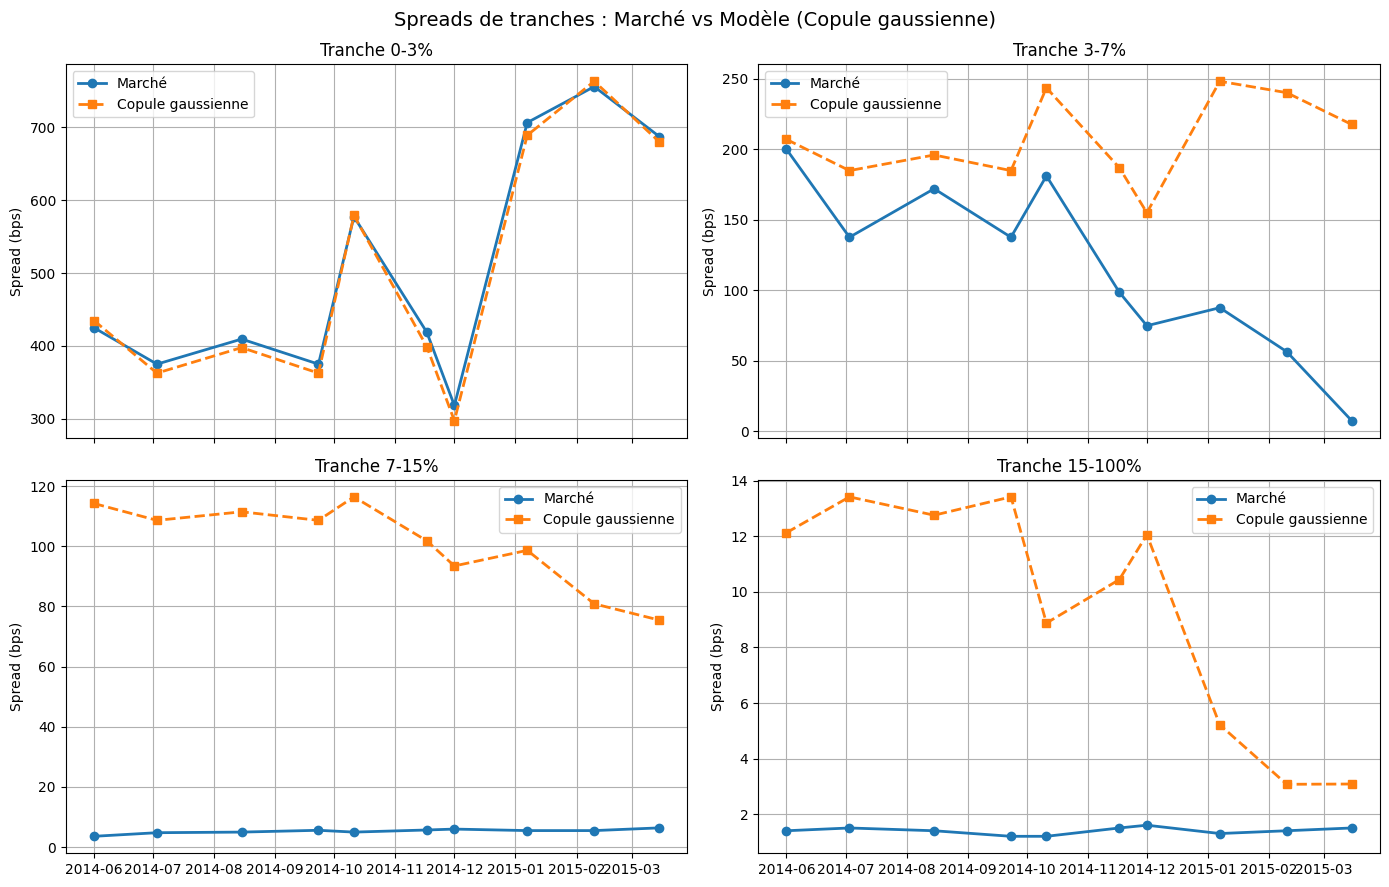

In [54]:
labels = ["0-3%", "3-7%", "7-15%", "15-100%"]
dates = df["Date"]

fig, axes = plt.subplots(2, 2, figsize=(14, 9), sharex=True)
axes = axes.flatten()

for k in range(4):
    ax = axes[k]

    ax.plot(
        dates,
        market_spreads[:, k] * 1e4,
        marker="o",
        label="Marché",
        linewidth=2
    )

    ax.plot(
        dates,
        model_spreads_all_dates[:, k] * 1e4,
        marker="s",
        linestyle="--",
        label="Copule gaussienne",
        linewidth=2
    )

    ax.set_title(f"Tranche {labels[k]}")
    ax.set_ylabel("Spread (bps)")
    ax.grid(True)
    ax.legend()

plt.suptitle("Spreads de tranches : Marché vs Modèle (Copule gaussienne)", fontsize=14)
plt.tight_layout()
plt.show()


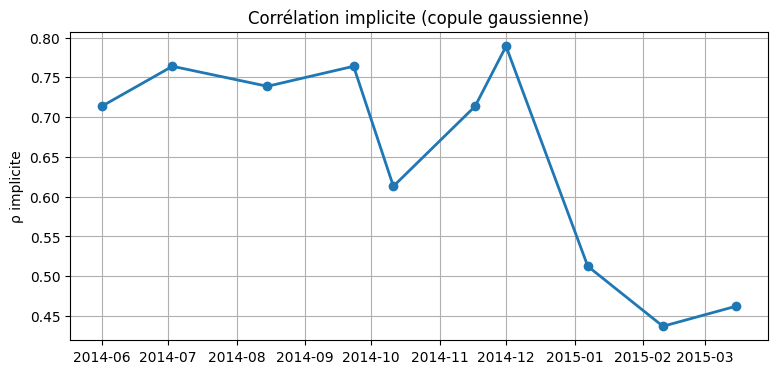

In [55]:
plt.figure(figsize=(9, 4))
plt.plot(dates, rho_t, marker="o", linewidth=2)
plt.ylabel("ρ implicite")
plt.title("Corrélation implicite (copule gaussienne)")
plt.grid(True)
plt.show()


On remarque que le modèle a beaucoup de difficulté à pricer correctement les tranches mezzanines et seniors pour lesquelles il a tendance à surestimer le risque par rapport au marché.

In [56]:
def price_single_tranche(rho, hazard, tranche_index):
    a, d = tranches[tranche_index]

    U = gaussian_copula_uniforms(rho)
    tau = -np.log(U) / hazard

    L_prev = np.zeros(M)
    default_leg = 0.0
    premium_leg = 0.0

    for t in payment_times:
        defaults = (tau <= t).sum(axis=1)
        L = (1 - R) * defaults / N
        Lt = tranche_loss(L, a, d)

        default_leg += discount(t) * np.mean(Lt - L_prev)

        outstanding_prev = d - a - L_prev
        outstanding_now = d - a - Lt
        premium_leg += discount(t) * np.mean(
            0.5 * (outstanding_prev + outstanding_now)
        )

        L_prev = Lt

    if premium_leg < 1e-10:
        return 0.0

    return default_leg / premium_leg


In [57]:
def implied_rho_tranche(market_spread, hazard, tranche_index):

    def objective(x):
        rho = x[0]
        model_spread = price_single_tranche(rho, hazard, tranche_index)
        return (model_spread - market_spread)**2

    res = differential_evolution(
        objective,
        bounds=[(0.01, 0.99)],
        strategy="best1bin",
        maxiter=20,
        popsize=10,
        seed=123,
        polish=True
    )

    return res.x[0]


On décide de calculer le coefficient de corrélation $\rho$ pour chaque tranche. Ceci permet d'observer un "smile" ou "skew" de corrélation, un phénomène connu lié à l'utilisation du modèle de copule gaussienne qui illustre l'impossibilité de pricer correctement chaque tranche. Ceci est notamment lié à l'indépendance des queues de distribution de la copule gaussienne.

In [58]:
attachment_points = [a for a, _ in tranches]

# Essayer de charger le cache du smile
smiles = load_smiles_cache()

if smiles is None:
    # Pas de cache, calculer le smile
    print("Calcul du smile de corrélation (première fois / cache expiré)...")
    smiles = []  # shape: (n_dates, n_tranches)

    for i in range(len(df)):
        h = hazard_from_index(df.loc[i, "CDS_Index"])
        implied_rhos = []

        for k in range(len(tranches)):
            rho_k = implied_rho_tranche(
                market_spreads[i, k],
                h,
                tranche_index=k
            )
            implied_rhos.append(rho_k)

        smiles.append(implied_rhos)

    smiles = np.array(smiles)
    
    # Sauvegarder en cache
    save_smiles_cache(smiles)


Cache smiles chargé: c:\Users\alexb\Documents\EI3\PROJET\Rapport_Pricing_CDO_synthétique\Simulation\cache\smiles_cache.pkl


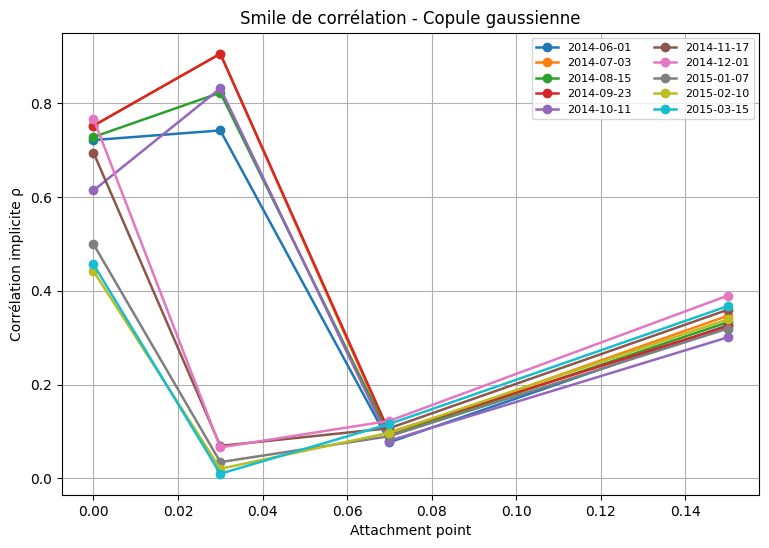

In [59]:
dates = df["Date"]

plt.figure(figsize=(9, 6))

for i in range(len(df)):
    plt.plot(
        attachment_points,
        smiles[i],
        marker="o",
        linewidth=1.8,
        label=dates[i].strftime("%Y-%m-%d")
    )

plt.xlabel("Attachment point")
plt.ylabel("Corrélation implicite ρ")
plt.title("Smile de corrélation - Copule gaussienne")
plt.grid(True)
plt.legend(fontsize=8, ncol=2)
plt.show()


C:\Users\alexb\AppData\Local\Temp\ipykernel_13948\1116349225.py:23: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


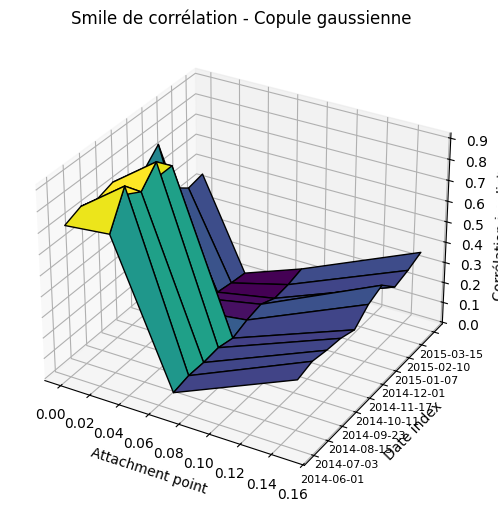

In [60]:
# Surface plot de la smile de corrélation
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection="3d")

# Convert dates to numeric values (days since first date)
dates_numeric = np.arange(len(dates))

X, Y = np.meshgrid(attachment_points, dates_numeric)
Z = smiles
ax.plot_surface(X, Y, Z, cmap="viridis", edgecolor="k")
ax.set_xlabel("Attachment point")
ax.set_ylabel("Date index")
ax.set_zlabel("Corrélation implicite ρ")
ax.set_title("Smile de corrélation - Copule gaussienne")

# Update y-axis labels to show actual dates
date_labels = [d.strftime("%Y-%m-%d") for d in dates]
ax.set_yticks(dates_numeric)
ax.set_yticklabels(date_labels, fontsize=8)

plt.tight_layout()
plt.show()

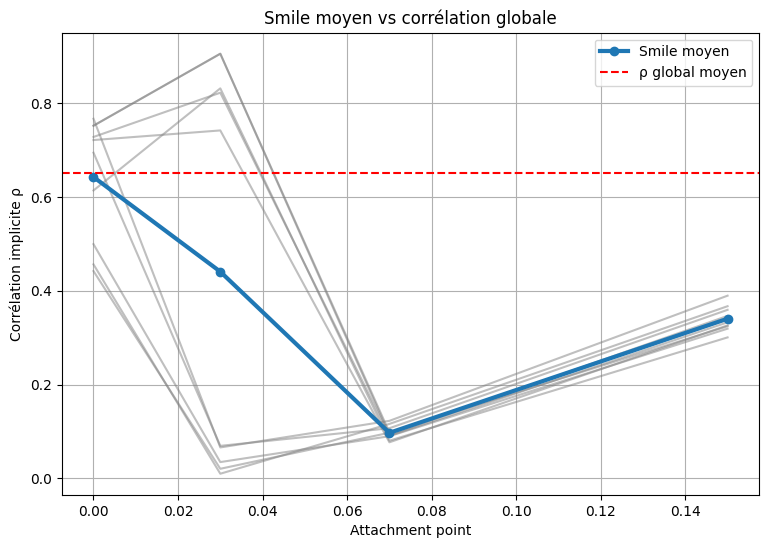

In [61]:
plt.figure(figsize=(9, 6))

for i in range(len(df)):
    plt.plot(
        attachment_points,
        smiles[i],
        color="gray",
        alpha=0.5
    )

plt.plot(
    attachment_points,
    np.mean(smiles, axis=0),
    marker="o",
    linewidth=3,
    label="Smile moyen"
)

plt.axhline(
    np.mean(rho_t),
    color="red",
    linestyle="--",
    label="ρ global moyen"
)

plt.xlabel("Attachment point")
plt.ylabel("Corrélation implicite ρ")
plt.title("Smile moyen vs corrélation globale")
plt.grid(True)
plt.legend()
plt.show()


Nous calculons les pertes espérées de chaque tranche de notre CDO à partir du modèle de Vasicek (LHP). Il s'agit d'une approximation analytique de la distribution de perte basée sur les hypothèses suivantes : portefeuille homogène, portefeuille grand, un facteur de corrélation et des défauts à maturité.
Il utilise la formule suivante : 

$ E[L] = \int_0^1 \Phi\left(\frac{\Phi^{-1}(p) - \sqrt{\rho} z}{\sqrt{1-\rho}}\right) f_Z(z) dz $

où $p$ est la probabilité de défaut individuelle, $\rho$ est la corrélation, $z$ est la variable aléatoire standard et $f_Z(z)$ est la densité de la variable aléatoire standard. Cette formule permet d'obtenir une approximation rapide de la perte espérée pour chaque tranche, ce qui est utile pour l'optimisation de $\rho$.

In [62]:
def portfolio_loss_distribution(rho, h, T, R, n_grid=5000):
    """
    Retourne une approximation de la loi de perte du portefeuille
    sous le modèle LHP / Vasicek.
    """

    y = np.linspace(-6, 6, n_grid)
    dy = y[1] - y[0]

    p = 1 - np.exp(-h * T)
    threshold = norm.ppf(p)

    L = (1 - R) * norm.cdf(
        (threshold - np.sqrt(rho) * y) / np.sqrt(1 - rho)
    )

    weights = norm.pdf(y) * dy
    weights /= weights.sum()

    return L, weights

def tranche_loss(L, a, d):
    return np.minimum(np.maximum(L - a, 0.0), d - a)

def tranche_loss_distribution(rho, h, T, R, a, d, n_grid=5000):
    """
    Loi de perte d'une tranche [a,d] sous LHP.
    """

    L_port, w = portfolio_loss_distribution(rho, h, T, R, n_grid)
    L_tr = tranche_loss(L_port, a, d)

    return L_tr, w


In [63]:
tranche_distributions = {}

for i in range(len(df)):

    rho = rho_t[i]
    h = hazard_from_index(df.loc[i, "CDS_Index"])
    
    for (a, d) in tranches:
        L_tr, w = tranche_loss_distribution(rho, h, T, R, a, d)
        tranche_distributions[(a, d)] = (L_tr, w)


In [64]:
def expected_tranche_loss(L_tr, w):
    return np.sum(L_tr * w)

for (a, d), (L_tr, w) in tranche_distributions.items():
    etl = expected_tranche_loss(L_tr, w)
    print(f"Tranche {a:.0%}-{d:.0%} | ETL = {etl:.6f}")


Tranche 0%-3% | ETL = 0.008668
Tranche 3%-7% | ETL = 0.003901
Tranche 7%-15% | ETL = 0.002844
Tranche 15%-100% | ETL = 0.001349


In [65]:
rho_grid = np.linspace(0.01, 0.99, 25)

etl_vs_rho = {tr: [] for tr in tranches}

for rho in rho_grid:
    for (a, d) in tranches:
        L_tr, w = tranche_loss_distribution(rho, h, T, R, a, d)
        etl_vs_rho[(a, d)].append(expected_tranche_loss(L_tr, w))


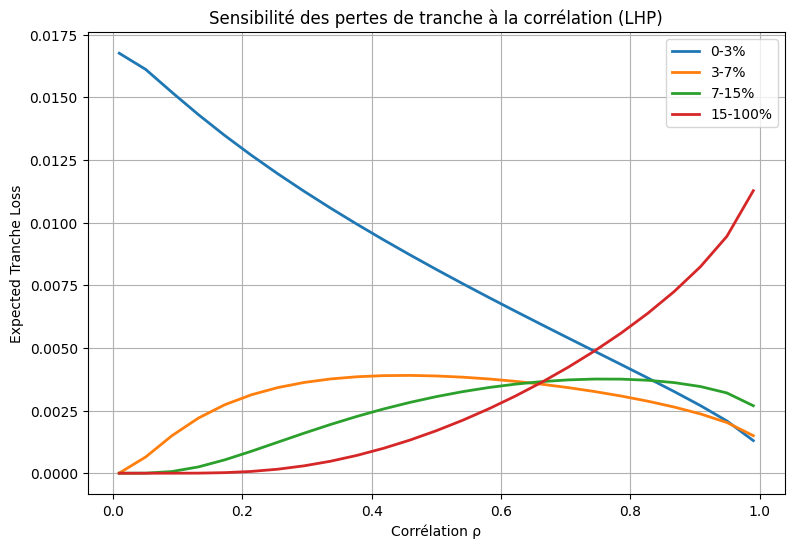

In [66]:
plt.figure(figsize=(9, 6))

for (a, d), etl in etl_vs_rho.items():
    plt.plot(
        rho_grid,
        etl,
        linewidth=2,
        label=f"{int(100*a)}-{int(100*d)}%"
    )

plt.xlabel("Corrélation ρ")
plt.ylabel("Expected Tranche Loss")
plt.title("Sensibilité des pertes de tranche à la corrélation (LHP)")
plt.grid(True)
plt.legend()
plt.show()